In [1]:
%autosave 0
import matplotlib.pyplot as plt
%matplotlib auto
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

import numpy as np
import seaborn as sns
import pandas 
from pandas import read_csv

import cv2
import cvlib

from skimage.transform import resize
from tqdm.notebook import tqdm

Autosave disabled
Using matplotlib backend: Qt5Agg


Using TensorFlow backend.


In [2]:
seed = 69
np.random.seed(seed)

df_base = read_csv('training_solutions_rev1.csv')

df_base.shape

(61578, 38)

In [3]:
df_train, df_test = train_test_split(df_base, test_size=0.3, random_state=seed)
df_train.shape, df_test.shape

((43104, 38), (18474, 38))

In [4]:
ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

def get_image(path, x1,y1, shape, crop_size):
    x = plt.imread(path)
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    x = x/255.
    return x
    
def get_all_images(dataframe, shape=IMG_SHAPE, crop_size=CROP_SIZE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
   
    sel = dataframe.values
    ids = sel[:,0].astype(int).astype(str)
    y_batch = sel[:,1:]
    x_batch = []
    
    for i in tqdm(ids):
        x = get_image('./images_training_rev1/'+i+'.jpg', x1,y1, shape=shape, crop_size=crop_size)
        x_batch.append(x)
    x_batch = np.array(x_batch)
    
    return x_batch, y_batch
        
X_train, y_train = get_all_images(df_train)
X_test, y_test = get_all_images(df_test)

In [5]:
X_train.shape, y_train.shape

((43104, 64, 64, 3), (43104, 37))

In [6]:
X_test.shape, y_test.shape

((18474, 64, 64, 3), (18474, 37))

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model = Sequential()
model.add(Conv2D(512, (3, 3), input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)))
model.add(Conv2D(256, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Conv2D(128, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Conv2D(128, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(GlobalMaxPooling2D())


model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(37))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=[root_mean_squared_error])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 512)       14336     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 256)       1179904   
_________________________________________________________________
activation_1 (Activation)    (None, 60, 60, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       590080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 128)       295040    
_________________________________________________________________
activation_2 (Activation)    (None, 26, 26, 128)      

In [8]:
batch_size = 5 #128
history = model.fit(X_train[0:20], y_train[0:20], epochs=30, validation_data=(X_test[0:20], y_test[0:20]))

Train on 20 samples, validate on 20 samples
Epoch 1/30
20/20 [==============================] - 20s 1s/step - loss: 0.6931 - root_mean_squared_error: 0.4373 - val_loss: 0.6896 - val_root_mean_squared_error: 0.4315
Epoch 2/30
20/20 [==============================] - 17s 853ms/step - loss: 0.6894 - root_mean_squared_error: 0.4352 - val_loss: 0.6300 - val_root_mean_squared_error: 0.3959
Epoch 3/30
20/20 [==============================] - 18s 889ms/step - loss: 0.6391 - root_mean_squared_error: 0.4062 - val_loss: 0.5159 - val_root_mean_squared_error: 0.3342
Epoch 4/30
20/20 [==============================] - 17s 870ms/step - loss: 0.6665 - root_mean_squared_error: 0.4012 - val_loss: 0.5434 - val_root_mean_squared_error: 0.3421
Epoch 5/30
20/20 [==============================] - 17s 865ms/step - loss: 0.5650 - root_mean_squared_error: 0.3638 - val_loss: 0.5779 - val_root_mean_squared_error: 0.3628
Epoch 6/30
20/20 [==============================] - 18s 922ms/step - loss: 0.5869 - root_mean_

<function matplotlib.pyplot.show(*args, **kw)>

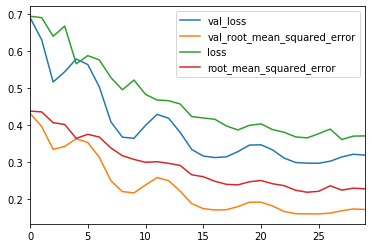

In [9]:
pandas.DataFrame(history.history).plot()
plt.grid = True
plt.show

In [10]:
pred = model.predict(X_test[0:100])

In [11]:
print(pred)

[[0.30510423 0.6406885  0.05935472 ... 0.09849349 0.09444714 0.11188009]
 [0.30518094 0.64061975 0.05943239 ... 0.09858996 0.09453923 0.11197266]
 [0.30950552 0.63725024 0.06338337 ... 0.10359207 0.09946537 0.11718312]
 ...
 [0.3061973  0.63984185 0.06032595 ... 0.09973556 0.09566483 0.11316606]
 [0.30778193 0.63859415 0.0617809  ... 0.10157496 0.09748399 0.11509153]
 [0.3082719  0.63823754 0.06220242 ... 0.1021122  0.09801376 0.11563674]]
